In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [29]:
mainpath = r'C:\Users\ChaakHei\Downloads'

# Baby function

In [30]:
def scale_data(series):
    overall_max = series.max()
    if overall_max >= 1e12:
        scaled = series / 1e12
        label = 'Volume (Trillions)'
    elif overall_max >= 1e9:
        scaled = series / 1e9
        label = 'Volume (Billions)'
    elif overall_max >= 1e6:
        scaled = series / 1e6
        label = 'Volume (Millions)'
    elif overall_max >= 1e3:
        scaled = series / 1e3
        label = 'Volume (Thousands)'
    else:
        scaled = series
        label = 'Volume (Units)'
    return scaled, label

In [31]:
def plot_weekly_price_volume(ticker):
    # Fetch data
    stock = yf.Ticker(ticker)

    hist = stock.history(period='2y')
    hist.reset_index(inplace=True)

    price = hist[['Date', 'Close', 'Volume']].copy()
    price['Date'] = pd.to_datetime(price['Date'])
    price.set_index('Date', inplace=True)

    weekly_price = price.resample('W-FRI').agg({'Close': 'last', 'Volume': 'sum'}).dropna()
    weekly_price.reset_index(inplace=True)
    weekly_price['Price_Diff'] = weekly_price['Close'].diff()
    weekly_price['Movement'] = np.where(weekly_price['Price_Diff'] >= 0, 'Up', 'Down')
    weekly_price['Movement'].fillna('Up', inplace=True)

    color_mapping = {'Up': 'green', 'Down': 'red'}
    weekly_price['Color'] = weekly_price['Movement'].map(color_mapping)
    weekly_price['Volume_Scaled'], volume_label = scale_data(weekly_price['Volume'])

    # Plotting
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price (USD)')
    ax1.plot(weekly_price['Date'], weekly_price['Close'], color='tab:blue', label='Close Price')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.set_ylabel(volume_label)
    ax2.bar(weekly_price['Date'], weekly_price['Volume_Scaled'], color=weekly_price['Color'], width = 5, alpha=0.2, label='Volume')
    ax2.tick_params(axis='y')
    plt.title(f"{ticker.upper()} - Closing Price and Weekly Volume Over Last 2 Years")
    fig.tight_layout()

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1, labels_1, loc='upper left')

    latest_date = weekly_price['Date'].max()
    start_date = weekly_price['Date'].min()
    padding = relativedelta(days=15)
    new_start_date = start_date - padding
    new_end_date = latest_date + padding

    tick_dates = [latest_date - relativedelta(months=6 * i) for i in range(0, 5)]
    tick_dates = [date for date in tick_dates if new_start_date <= date <= new_end_date]

    ax1.set_xticks(tick_dates)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.set_xlim([new_start_date, new_end_date])

    plt.show()
    #save the output as an image in the mainpath
    fig.savefig(f"{mainpath}\\{ticker}_price_volume.png")


In [32]:
def fetch(ticker, selected_columns):

  # Initialize the ticker object
  stock = yf.Ticker(ticker)

  # Fetch quarterly financials
  quarterly_financials = stock.quarterly_financials

  # Transpose the DataFrame to have dates as rows
  quarterly_financials = quarterly_financials.transpose()

  # Ensure that the selected columns exist in the fetched data
  available_columns = [col for col in selected_columns if col in quarterly_financials.columns]
  if not available_columns:
      raise ValueError(f"None of the selected columns {selected_columns} are available for ticker {ticker}.")

  # Select the desired columns and take the latest 5 quarters
  quarterly_financials = quarterly_financials[available_columns].head(5)

  # Convert the index to datetime objects (quarter end dates)
  quarterly_financials.index = pd.to_datetime(quarterly_financials.index)

  # Sort the DataFrame by date in ascending order
  quarterly_financials = quarterly_financials.sort_index()

  # Create the 'Quarter_End_Date' column as "Qn YYYY"
  data_dict = {
      'Quarter_End_Date': [
          f"Q{date.quarter} {date.year}" for date in quarterly_financials.index
      ]
  }

  # Dynamically add each selected metric to the data dictionary
  for col in available_columns:
      data_dict[col] = quarterly_financials[col].values

  # Create the DataFrame from the data dictionary
  data = pd.DataFrame(data_dict)

  # Reset the index to have a clean integer index
  data = data.reset_index(drop=True)

  return data

In [38]:
def plot_financials_line(data, ticker):
    """
    Plots line charts for Total Revenue and Gross Profit over time.

    Parameters:
    - data (pd.DataFrame): DataFrame containing 'Total Revenue', 'Gross Profit', and 'Quarter_End_Date' columns.
    - ticker (str): Stock ticker symbol.
    """
    # Check if both required columns are present
    required_columns = ['Total Revenue', 'Gross Profit', 'Quarter_End_Date']
    for col in required_columns:
        if col not in data.columns:
            raise ValueError(f"Required column '{col}' is missing from the data.")

    # Determine the scaling factor based on the maximum value among both metrics
    max_revenue = data['Total Revenue'].max()
    max_gross = data['Gross Profit'].max()
    overall_max = max(max_revenue, max_gross)

    if overall_max >= 1e12:
        data['Total_Revenue_Scaled'] = data['Total Revenue'] / 1e12
        data['Gross_Profit_Scaled'] = data['Gross Profit'] / 1e12
        y_label = 'Amount (Trillions USD)'
    elif overall_max >= 1e9:
        data['Total_Revenue_Scaled'] = data['Total Revenue'] / 1e9
        data['Gross_Profit_Scaled'] = data['Gross Profit'] / 1e9
        y_label = 'Amount (Billions USD)'
    elif overall_max >= 1e6:
        data['Total_Revenue_Scaled'] = data['Total Revenue'] / 1e6
        data['Gross_Profit_Scaled'] = data['Gross Profit'] / 1e6
        y_label = 'Amount (Millions USD)'
    else:
        data['Total_Revenue_Scaled'] = data['Total Revenue']
        data['Gross_Profit_Scaled'] = data['Gross Profit']
        y_label = 'Amount (USD)'

    # Create plot
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot Total Revenue as a line
    line1, = ax.plot(data['Quarter_End_Date'], data['Total_Revenue_Scaled'],
                     marker='o', label='Total Revenue', color='skyblue', linestyle='-')

    # Plot Gross Profit as a line
    line2, = ax.plot(data['Quarter_End_Date'], data['Gross_Profit_Scaled'],
                     marker='o', label='Gross Profit', color='salmon', linestyle='-')

    # Formatting the y-axis with commas and proper scaling
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.2f}'))

    # Labels and Title
    ax.set_xlabel('Quarter', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(f"{ticker.upper()} - Quarterly Total Revenue and Gross Profit Over Time",
                 fontsize=14, fontweight='bold')

    # Setting the positions and labels of the x-axis ticks
    ax.set_xticks(np.arange(len(data)))
    ax.set_xticklabels(data['Quarter_End_Date'], rotation=45, ha='right')

    # Add legend
    ax.legend()

    # Annotate data points with their values
    for x, y in enumerate(data['Total_Revenue_Scaled']):
        ax.annotate(f'{y:,.2f}',
                    xy=(x, y),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8, color='skyblue')

    for x, y in enumerate(data['Gross_Profit_Scaled']):
        ax.annotate(f'{y:,.2f}',
                    xy=(x, y),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8, color='salmon')

    # Add grid for better readability
    ax.grid(axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()

    # Show the plot
    plt.show()
    #save the output as an image in the mainpath
    fig.savefig(f"{mainpath}\\{ticker}_financials_line.png")

In [39]:
def plot_financials(data, ticker):
    # Check if both required columns are present
    required_columns = ['Total Revenue', 'Gross Profit']
    for col in required_columns:
        if col not in data.columns:
            raise ValueError(f"Required column '{col}' is missing from the data.")

    # Determine the scaling factor based on the maximum value among both metrics
    max_revenue = data['Total Revenue'].max()
    max_gross = data['Gross Profit'].max()
    overall_max = max(max_revenue, max_gross)

    if overall_max >= 1e12:
        data['Total_Revenue_Scaled'] = data['Total Revenue'] / 1e12
        data['Gross_Profit_Scaled'] = data['Gross Profit'] / 1e12
        y_label = 'Amount (Trillions USD)'
    elif overall_max >= 1e9:
        data['Total_Revenue_Scaled'] = data['Total Revenue'] / 1e9
        data['Gross_Profit_Scaled'] = data['Gross Profit'] / 1e9
        y_label = 'Amount (Billions USD)'
    elif overall_max >= 1e6:
        data['Total_Revenue_Scaled'] = data['Total Revenue'] / 1e6
        data['Gross_Profit_Scaled'] = data['Gross Profit'] / 1e6
        y_label = 'Amount (Millions USD)'
    else:
        data['Total_Revenue_Scaled'] = data['Total Revenue']
        data['Gross_Profit_Scaled'] = data['Gross Profit']
        y_label = 'Amount (USD)'

    # Set the width of each bar
    bar_width = 0.35
    index = np.arange(len(data))

    # Create plot
    fig, ax = plt.subplots(figsize=(14, 7))

    # Bar plot for Total Revenue
    bars1 = ax.bar(index - bar_width/2, data['Total_Revenue_Scaled'], bar_width, label='Total Revenue', color='skyblue')

    # Bar plot for Gross Profit
    bars2 = ax.bar(index + bar_width/2, data['Gross_Profit_Scaled'], bar_width, label='Gross Profit', color='salmon')

    # Formatting the y-axis with commas and proper scaling
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.2f}'))

    # Labels and Title
    ax.set_xlabel('Quarter', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(f"{ticker.upper()} - Quarterly Total Revenue and Gross Profit Over Time", fontsize=14, fontweight='bold')

    # Setting the positions and labels of the x-axis ticks
    ax.set_xticks(index)
    ax.set_xticklabels(data['Quarter_End_Date'], rotation=45, ha='right')

    # Add legend
    ax.legend()

    # Annotate bars with their values
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:,.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    # Add grid for better readability
    ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()

    # Show the plot
    plt.show()
    #save the output as an image in the mainpath
    fig.savefig(f"{mainpath}\\{ticker}_financials.png")

In [40]:
def cal_change(data, selected_columns):
    # Calculate Year-over-Year (YoY) change for each metric
    yoy_change = ((data.loc[4, selected_columns] - data.loc[0, selected_columns]) / data.loc[0, selected_columns]) * 100

    # Calculate Quarter-over-Quarter (QoQ) change for each metric
    qoq_change = ((data.loc[4, selected_columns] - data.loc[3, selected_columns]) / data.loc[3, selected_columns]) * 100

    # Create a new DataFrame to store the changes
    changes_df = pd.DataFrame({
        'Metric': selected_columns,
        'Year-over-Year Change (%)': yoy_change.values,
        'Quarterly Change (%)': qoq_change.values
    })

    # Round the percentage changes to two decimal places
    changes_df['Year-over-Year Change (%)'] = changes_df['Year-over-Year Change (%)'].round(2)
    changes_df['Quarterly Change (%)'] = changes_df['Quarterly Change (%)'].round(2)

    # Convert numerical columns to strings with two decimal places for consistent formatting
    changes_df['Year-over-Year Change (%)'] = changes_df['Year-over-Year Change (%)'].map("{:.2f}".format)
    changes_df['Quarterly Change (%)'] = changes_df['Quarterly Change (%)'].map("{:.2f}".format)

    # Create a larger matplotlib figure for more space
    fig_height = max(2, len(changes_df) * 0.5)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    ax.axis('tight')
    ax.axis('off')

    # Create the table with column colors for better readability
    table = ax.table(cellText=changes_df.values,
                     colLabels=changes_df.columns,
                     cellLoc='center',
                     loc='center',
                     colColours=["#f2f2f2"] * len(changes_df.columns))  # Header color

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)

    # Adjust column widths manually for better spacing
    for i, column in enumerate(changes_df.columns):
        table.auto_set_column_width(i)
        # Alternatively, set a fixed width in points (uncomment the next line)
        # table.column(i).set_width(1.0)

    # Increase row height for more vertical space and add borders
    for key, cell in table.get_celld().items():
        cell.set_height(0.7)  # Adjust as needed
        cell.set_edgecolor('black')  # Add cell borders for clarity

    # Conditional coloring for data cells
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            # Header row already has a background color
            continue
        if col == 0:
            # 'Metric' column - no coloring
            continue
        # Retrieve the numerical value for comparison
        if col == 1:
            # Year-over-Year Change
            value = yoy_change.iloc[row - 1]
        elif col == 2:
            # Quarterly Change
            value = qoq_change.iloc[row - 1]
        else:
            value = 0  # Default case, though not expected

        # Set cell background color based on the value
        if value > 0:
            cell.set_facecolor('#d4edda')  # Light Green
        elif value < 0:
            cell.set_facecolor('#f8d7da')  # Light Red
        else:
            cell.set_facecolor('#ffffff')  # White for zero or neutral

    # Adjust text properties to effectively create padding and ensure readability
    for key, cell in table.get_celld().items():
        text = cell.get_text()
        text.set_fontsize(12)    # Ensure text is readable
        text.set_ha('center')    # Horizontal alignment
        text.set_va('center')    # Vertical alignment

    # Adjust layout to make sure everything fits without overlapping
    plt.tight_layout()

    # Display the table as an image
    plt.show()
    #save the output as an image in the mainpath
    fig.savefig(f"{mainpath}\\{ticker}_financials_change.png")

# Main function

In [41]:
def main_function(ticker):

  ticker = ticker
  selected_columns = ['Basic EPS', 'Total Revenue', 'Gross Profit']

  #functions for plotting and calculation

  plot_weekly_price_volume(ticker)

  data= fetch(ticker, selected_columns)

  plot_financials_line(data, ticker)

  changes_df = cal_change(data, selected_columns)

  return changes_df

# Output

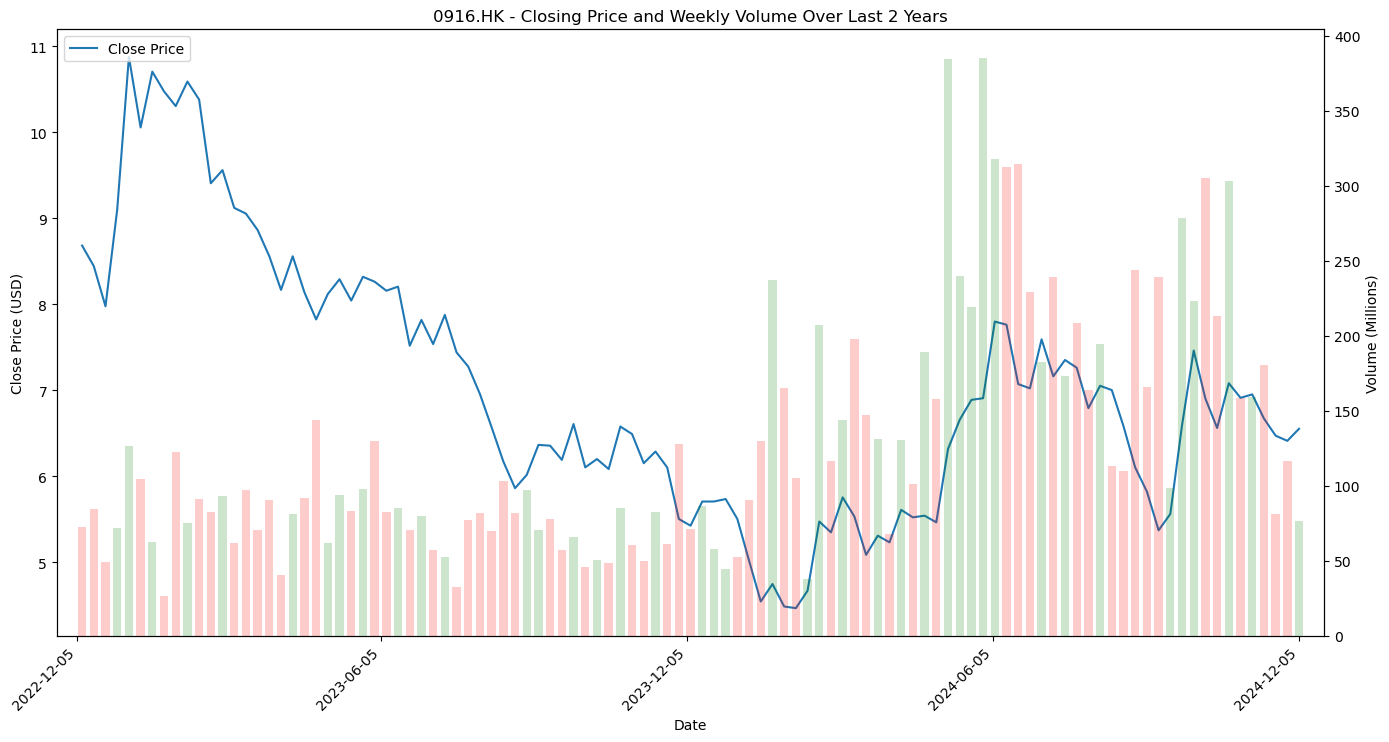

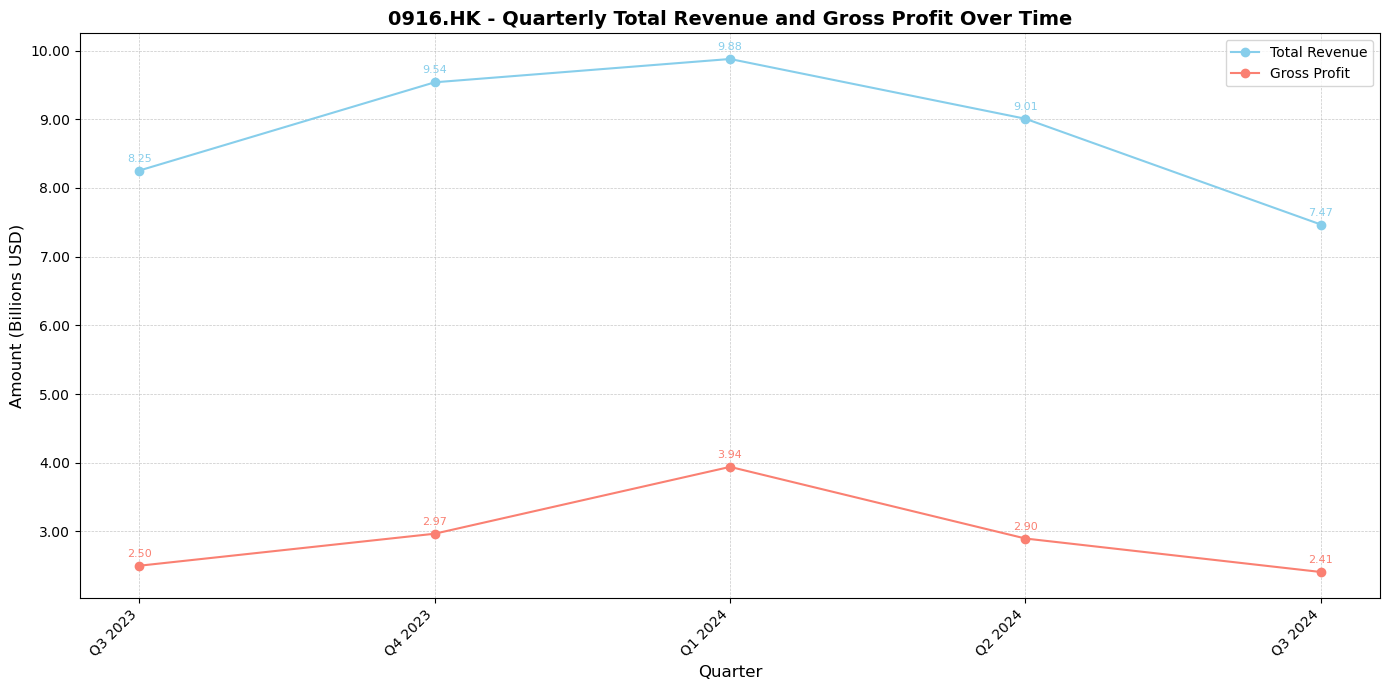

TypeError: loop of ufunc does not support argument 0 of type float which has no callable rint method

In [42]:
main_function('0916.HK')